In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install roboflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [3]:
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

import json
import numpy as np
from PIL import Image
import shutil
from roboflow import Roboflow
from kaggle_secrets import UserSecretsClient
from sklearn.utils import class_weight
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Cropping2D

In [4]:
rf = Roboflow(api_key=UserSecretsClient().get_secret("ROBOFLOW_API_KEY"))
project = rf.workspace("tinted-ypy9v").project("cs2-object-detection")
version = project.version(4)
dataset = version.download("coco")
                
dataset_dir = dataset.location
output_dir = dataset_dir + "_unet"

os.makedirs(output_dir, exist_ok=True)

for split in ["train", "valid", "test"]:
    print(f"Processing {split}...")
    os.makedirs(os.path.join(output_dir, "masks"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
    
    with open(os.path.join(dataset_dir, split, "_annotations.coco.json")) as f:
        data = json.load(f)

    image_masks = {}

    for annotation in data["annotations"]:
        image_info = data["images"][annotation["image_id"]]

        img_path = os.path.join(dataset_dir, split, image_info["file_name"])
        if image_info["file_name"] not in image_masks:
            img = Image.open(img_path)
            img.save(os.path.join(output_dir, "images", image_info["file_name"]))
            image_masks[image_info["file_name"]] = np.zeros((image_info["height"], image_info["width"], 1), dtype=np.uint8)  

        mask = image_masks[image_info["file_name"]]

        category_id = annotation["category_id"]

        for seg in annotation["segmentation"]:
            polygon = np.array(seg, dtype=np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [polygon], category_id)

    for image_name, mask in image_masks.items():
        mask_filename = os.path.splitext(image_name)[0] + ".png"
        cv2.imwrite(os.path.join(output_dir, "masks", mask_filename), mask)

shutil.rmtree(dataset_dir)
os.rename(output_dir, dataset_dir)
print("Done!")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CS2-Object-detection-4 in coco:: 100%|██████████| 2699/2699 [00:00<00:00, 5760.76it/s]


Processing train...
Processing valid...
Processing test...
Done!


In [5]:
IMG_WIDTH = 400
IMG_HEIGHT = 400

In [6]:
images_path = os.path.join(dataset_dir, "images")
masks_path = os.path.join(dataset_dir, "masks")

In [7]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 15.2 MB/s eta 0:00:00


In [8]:
!git clone https://github.com/ItsSpirax/temp/

Cloning into 'temp'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 0), reused 4 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), done.


In [9]:
import cv2
import os
import glob
import numpy as np
from ultralytics import YOLO

obj_model = YOLO("temp/model.pt")

def process_images_and_masks(image_dir, mask_dir, output_image_folder, output_mask_folder):
    os.makedirs(output_image_folder, exist_ok=True)
    os.makedirs(output_mask_folder, exist_ok=True)

    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

    for img_path in image_paths:
        filename = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = os.path.join(mask_dir, f"{filename}.png")

        if not os.path.exists(mask_path):
            continue

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            continue

        results = obj_model(img_path, verbose=False)

        h, w, _ = img.shape

        black_mask = np.zeros((h, w), dtype=np.uint8)

        for result in results:
            for box in result.boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)

                x1 = max(0, x1 - 20)
                y1 = max(0, y1 - 20)
                x2 = min(w, x2 + 20)
                y2 = min(h, y2 + 20)

                cv2.rectangle(black_mask, (x1, y1), (x2, y2), 255, thickness=-1)

        black_mask_3ch = cv2.merge([black_mask, black_mask, black_mask])

        img = cv2.bitwise_and(img, black_mask_3ch)
        mask = cv2.bitwise_and(mask, black_mask)

        cv2.imwrite(os.path.join(output_image_folder, f"{filename}.jpg"), img)
        cv2.imwrite(os.path.join(output_mask_folder, f"{filename}.png"), mask)

output_image_folder = "processed_images"
output_mask_folder = "processed_masks"

print("Starting")
process_images_and_masks(images_path, masks_path, output_image_folder, output_mask_folder)
print("Done")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting
Done


In [10]:
images_path = "/kaggle/working/processed_images/"
masks_path = "/kaggle/working/processed_masks/"

image_files = sorted(os.listdir(images_path))
mask_files = sorted(os.listdir(masks_path))

In [11]:
X = np.zeros((len(image_files), IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.uint8)
y = np.zeros((len(mask_files), IMG_WIDTH, IMG_HEIGHT, 1), dtype=np.uint8)

In [12]:
print("Processing Images")
for n, img_name in enumerate(image_files):
    file_path = os.path.join(images_path, img_name)
    image = imread(file_path)
    image = resize(image, (IMG_WIDTH, IMG_HEIGHT), mode="constant", preserve_range=True)
    X[n] = image

print("Processing Masks")
for n, mask_name in enumerate(mask_files):
    file_path = os.path.join(masks_path, mask_name)
    mask = imread(file_path, as_gray=True)
    mask = np.expand_dims(resize(mask, (IMG_WIDTH, IMG_HEIGHT), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

print("Finished Processing")

Processing Images
Processing Masks
Finished Processing


In [13]:
y_reshaped = y.reshape(-1)
y_unique = np.unique(y_reshaped)
weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = y_unique, y = y_reshaped)

class_weights = dict(enumerate(weights))

del y_reshaped
del y_unique
del weights

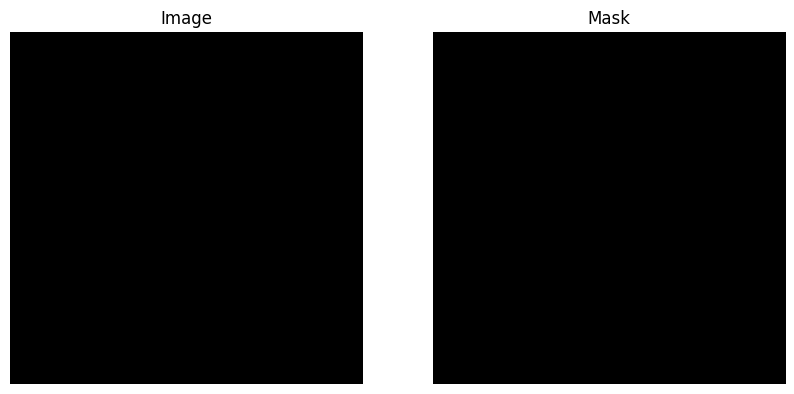

In [14]:
image_random = random.randint(0, len(X) - 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[image_random].astype(np.uint8))
plt.axis("off")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(y[image_random]), cmap="gray")
plt.axis("off")
plt.title("Mask")

plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

print(f"X_train: {X_train.shape}\nY_train: {y_train.shape}")

X_train: (978, 400, 400, 3)
Y_train: (978, 400, 400, 1)


In [16]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [17]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout, Cropping2D

def unet_model(img_height, img_width, num_classes):
    inputs = Input((img_height, img_width, 3))

    # Encoder
    def conv_block(x, filters):
        x = Conv2D(filters, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = MaxPooling2D((2,2))(c)
        return c, p

    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)

    # Bottleneck
    c5 = conv_block(p4, 512)
    c5 = Dropout(0.3)(c5)

    # Decoder with cropping to fix shape mismatch
    def decoder_block(x, skip, filters):
        x = Conv2DTranspose(filters, (2,2), strides=(2,2), padding='same')(x)
        
        # Crop skip connection if shape mismatches
        crop_h = skip.shape[1] - x.shape[1]
        crop_w = skip.shape[2] - x.shape[2]
        if crop_h > 0 or crop_w > 0:
            skip = Cropping2D(((crop_h // 2, crop_h - crop_h // 2),
                               (crop_w // 2, crop_w - crop_w // 2)))(skip)

        x = concatenate([x, skip])
        x = conv_block(x, filters)
        return x

    c6 = decoder_block(c5, c4, 256)
    c7 = decoder_block(c6, c3, 128)
    c8 = decoder_block(c7, c2, 64)
    c9 = decoder_block(c8, c1, 32)

    # Output Layer
    outputs = Conv2D(num_classes, (1,1), activation='softmax')(c9)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="U-Net")

NUM_CLASSES = 3

model = unet_model(IMG_WIDTH, IMG_HEIGHT, NUM_CLASSES)

In [19]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', dice_coefficient])

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 400, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 400, 400, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 400, 400, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 400, 400, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 400, 400, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 200, 200, 32)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 200, 200, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 200, 200, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 200, 200, 64)   │         36,928 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 200, 200, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 100, 100, 64)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 100, 100, 128)  │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 100, 100, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 100, 100, 128)  │        147,584 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 100, 100, 128)  │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 7,771,939 (29.65 MB)

 Trainable params: 7,766,051 (29.63 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [21]:
sample_weight = np.zeros_like(y_train, dtype=np.float32)

for cls, weight in class_weights.items():
    sample_weight[..., cls] = weight

sample_weight = np.sum(sample_weight * y_train, axis=-1)

In [22]:
import gc
import sys

vars_to_delete = ["X", "y"]
for var_name in vars_to_delete:
    if var_name in globals():
        var_size = sys.getsizeof(globals()[var_name])
        if var_size > 1024:
            print(f"{var_name}: {var_size / 1024:.2f} KB")
        del globals()[var_name]

gc.collect()

X: 655312.66 KB
y: 218437.66 KB


5672

In [23]:
model.fit(X_train, y_train, validation_split=0.1, sample_weight=sample_weight, batch_size=8, epochs=50)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 70s 312ms/step - accuracy: 0.6947 - dice_coefficient: 0.4085 - loss: 0.7258 - val_accuracy: 0.9677 - val_dice_coefficient: 0.5513 - val_loss: 0.3405
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.9717 - dice_coefficient: 0.6606 - loss: 0.2605 - val_accuracy: 0.9815 - val_dice_coefficient: 0.7188 - val_loss: 0.2752
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.9791 - dice_coefficient: 0.8507 - loss: 0.1231 - val_accuracy: 0.0216 - val_dice_coefficient: 0.1492 - val_loss: 1.3253
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - accuracy: 0.9773 - dice_coefficient: 0.9172 - loss: 0.0976 - val_accuracy: 0.0089 - val_dice_coefficient: 0.0319 - val_loss: 1.9409
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - accuracy: 0.9762 - dice_coefficient: 0.9427 - loss: 0.0742 - val_accuracy: 0.9786 - val_dice_coefficient: 0.6623 - val_loss: 0.2306
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step 

In [24]:
model.save_weights("model.weights.h5")

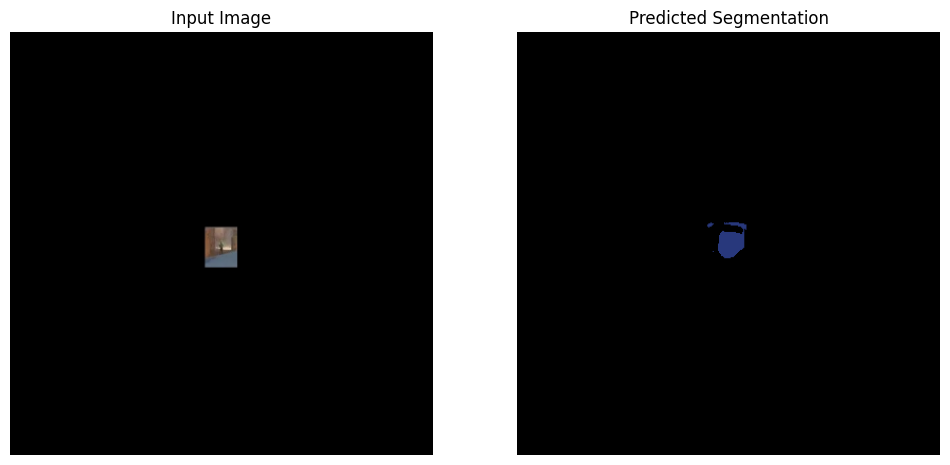

In [25]:
img = X_test[random.randint(0, len(X_test) - 1)]

prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)
class_map = np.argmax(prediction, axis=-1)[0]

color_mapping = {
    0: [0, 0, 0],
    1: [40, 56, 124],
    2: [244, 168, 24]
}

image = np.zeros((class_map.shape[0], class_map.shape[1], 3), dtype=np.uint8)

for class_id, color in color_mapping.items():
    image[class_map == class_id] = color

image = image.astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img)
axes[0].set_title("Input Image")
axes[0].axis("off")

axes[1].imshow(image)
axes[1].set_title("Predicted Segmentation")
axes[1].axis("off")

plt.show()
